# <span style="color:green">__Data Science Bootcamp__

## <span style="color:black">__Project__: Machine Learning Project

---
### <span style="color:navy">__Context__

<span style="color:dark_grey">

## Kickstarter Project Success

Analyse and model success factors of kickstarter campaigns. Give new projects an idea what is needed for a successful funding and potentially even predict campaign success upfront.
In recent years, the range of funding options for projects created by individuals and small companies has expanded considerably. In addition to savings, bank loans, friends & family funding and other traditional options, crowdfunding has become a popular and readily available alternative.

Kickstarter, founded in 2009, is one particularly well-known and popular crowdfunding platform. It has an all-or-nothing funding model, whereby a project is only funded if it meets its goal amount; otherwise no money is given by backers to a project.
A huge variety of factors contribute to the success or failure of a project — in general, and also on Kickstarter. Some of these are able to be quantified or categorized, which allows for the construction of a model to attempt to predict whether a project will succeed or not. The aim of this project is to construct such a model and also to analyse Kickstarter project data more generally, in order to help potential project creators assess whether or not Kickstarter is a good funding option for them, and what their chances of success are.

**Source:** Kickstarter Project Success Data, containing information about their campaigns.

**Final Deliverables:**
1. Slide deck PDF pushed to GitHub designed for non-technical stakeholders that outline findings, recommendations, and future work (10 min presentation).
2. Jupyter notebook following PEP8 designed for data science/technical audience.
3. (Recommended) Python script for generating (takes .csv as argument and saves the model locally) and running your model from the terminal (takes test.csv and model as arguments and outputs accuracy and predictions as .csv) (you can still use the template repo : https://github.com/neuefische/ds-ml-project-template)

**Technical:**
* hh


---
### <span style="color:navy">__Importing Packages and Data__


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timezone
import json

# Libraries for data import
import os
import glob

# Preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

In [3]:
# Kickstarter data

path = "data/data-2"
all_files = glob.glob(os.path.join(path + "/*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
data = pd.concat(li, axis=0, ignore_index=True)

df = data.copy()

In [4]:
# data.to_csv('data/csv_files_combined.csv',index=False)

In [5]:
#df = pd.read_csv('data/csv_files_combined.csv')

In [6]:
# Formatting the columns
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 200)

# pd.set_option('display.max_colwidth', None)


---
### <span style="color:navy">__Exploratory Data Analysis__

In [7]:
#Print the shape of the data

print('Kickstarter dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Kickstarter dataset
# observations: 209222
# features:     36


In [8]:
#df.head(5)

In [9]:
#df.category[0]

In [10]:
#df.shape

In [11]:
#df.columns

In [12]:
#df.info()

In [13]:
#df.describe()

> Relevant columns in JSON format were separated, their features were concatenated to the main data frame and some irrelevant columns were dropped.

json plan:
* first explode json columns category and location
* select columns that we want to keep from json dataframes categroy and location
* concat selected columns to original dataframe
* delete all columns we dont want (including original json columns)

In [14]:
# define function to explode json columns

def explode_json(df, col_name):
    ''' explodes json columns'''
    exploded = pd.json_normalize(df[col_name].apply(json.loads))
    return exploded

In [15]:
# explode and concatenate JSON columns location and category

# explode 'location', first replace nan rows with 'empty_json'
empty_json = '{"id":"nan","name":"nan","slug":"nan","short_name":"nan","displayable_name":"nan","localized_name":"nan","country":"nan","state":"nan","type":"nan","is_root":"nan","urls":{"web":{"discover":"nan","location":"nan"},"api":{"nearby_projects":"nan"}}}'
df['location'] = df['location'].fillna(empty_json)
df_location_exploded = explode_json(df, 'location')

# select location columns to keep
df_location_exploded_keep = df_location_exploded[['country', 'state','localized_name','type']]
df_location_exploded_keep.columns = df_location_exploded_keep.columns.str.replace('state', 'loc_state')
df_location_exploded_keep.columns = df_location_exploded_keep.columns.str.replace('country', 'loc_country')
df_location_exploded_keep.columns = df_location_exploded_keep.columns.str.replace('localized_name', 'city')


# explode category, then split slug column by "/"
df_category_exploded = explode_json(df, 'category')
df_category_exploded[['slug_1','slug_2']] = df_category_exploded['slug'].str.split('\/',expand=True)

# select category columns to keep
df_category_exploded_keep = df_category_exploded[['name','position','slug_1','slug_2']]

df_category_exploded_keep.columns = df_category_exploded_keep.columns.str.replace('name', 'name_cat')



In [16]:
# concatenate exploded JSON columns

df = pd.concat([df,df_location_exploded_keep,df_category_exploded_keep], axis=1)

In [17]:
#df.columns

In [18]:
df.head(5)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,loc_country,loc_state,city,type,name_cat,position,slug_1,slug_2
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,USD,1552539775,False,NaN,1.000000,28000.0,2108505034,NaN,False,NaN,1548223375,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",Babalus Children's Shoes,NaN,"{""key"":""assets/023/667/205/a565fde5382d6b53276...",28645.0,"{""id"":3508024,""project_id"":3508024,""state"":""in...",babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28645.000000,international,US,CA,Novato,Town,Footwear,5,fashion,footwear
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,USD,1504976459,False,NaN,1.000000,1000.0,928751314,NaN,False,NaN,1502384459,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,NaN,"{""key"":""assets/017/766/989/dd9f18c773a8546d996...",1950.0,"{""id"":3094785,""project_id"":3094785,""state"":""ac...",the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1950.000000,domestic,US,TX,Euless,Town,Playing Cards,4,games,playing cards
2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,USD,1371013395,False,NaN,1.000000,15000.0,928014092,NaN,False,NaN,1368421395,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",NaN,"{""key"":""assets/011/433/681/489fd66f7861fefd8c8...",22404.0,"{""id"":359847,""project_id"":359847,""state"":""inac...",record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",22404.000000,international,US,CA,Hollywood,Suburb,Rock,17,music,rock
3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,USD,1489425776,False,NaN,1.308394,10000.0,596091328,NaN,False,NaN,1484245376,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,NaN,"{""key"":""assets/015/091/198/216fbf1bdc3739e7971...",136.0,"{""id"":2825329,""project_id"":2825329,""state"":""in...",the-mist-of-tribunal-a-card-game,https://www.kickstarter.com/discover/categorie...,False,False,failed,1489425776,1.216066,"{""web"":{""project"":""https://www.kickstarter.com...",165.384934,domestic,LT,Kaunas County,Kaunas,Town,Playing Cards,4,games,playing cards
4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,USD,1357763527,False,NaN,1.000000,2800.0,998516049,NaN,False,NaN,1355171527,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,NaN,"{""key"":""assets/011/457/844/37ba63d35fefaba76e9...",2820.0,"{""id"":417385,""project_id"":417385,""state"":""inac...",help-change-the-face-of-brain

In [19]:
# dropJSON and unwanted columns
# originally: df = df.drop(['blurb', 'category', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'fx_rate', 'id', 'location', 'name', 'photo', 'profile', 'source_url', 'urls'], axis=1)

# drop json columns
df = df.drop(['category', 'creator','location','photo','profile'], axis=1)

# drop unwanted information
df = df.drop(['currency_symbol', 'currency_trailing_code', 'source_url', 'urls'], axis=1)


In [20]:
#df.columns = df.columns.str.replace('category_1', 'category')

In [21]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'created_at', 'currency', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'name',
       'permissions', 'pledged', 'slug', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type',
       'loc_country', 'loc_state', 'city', 'type', 'name_cat', 'position',
       'slug_1', 'slug_2'],
      dtype='object')

# create combined columns

### columns to keep from [L. Lewis](https://github.com/L-Lewis/Kickstarter-success-machine-learning/blob/master/Kickstarter-project.ipynb)
* backers_count                  
* category                       
* country                        
* created_at                     
* deadline                       
* id                             
* is_starrable                   
* launched_at                    
* staff_pick                     
* state                          
* usd_pledged                    
* blurb_length                   
* sub_category                   
* usd_goal                       
* name_length                    
* creation_to_launch_days        
* campaign_days                  
* launch_day                     
* deadline_day                   
* launch_month                   
* deadline_month                 
* launch_time                    
* deadline_time                  
* pledge_per_backer          

### dates:

* created_at
* deadline
* launched_at
* launch_day
* launch_time
* launch_month
* deadline_day
* deadline_month
* deadline_time
* creation_to_launch_days
* campaign_days

In [22]:
df['created_at'] = df.created_at.apply(datetime.fromtimestamp)


In [23]:
# creating datetime formatted deadline deadline_time, deadline_month, deadline_day

df['deadline'] = df.deadline.apply(datetime.fromtimestamp)

df["deadline_month"] = df["deadline"].dt.strftime("%M")
df["deadline_day"] = df["deadline"].dt.strftime("%d")
df["deadline_time"] = df["deadline"].dt.strftime("%H") # hour of creation/launch/deadline



In [24]:
# creating launch_day, launch_time,launch_month

df['launched_at'] = df.launched_at.apply(datetime.fromtimestamp)

df["launch_month"] = df["launched_at"].dt.strftime("%M")
df["launch_day"] = df["launched_at"].dt.strftime("%d")
df["launch_time"] = df["launched_at"].dt.strftime("%H") # hour of creation/launch/deadline



In [25]:
# creating creation_to_launch_days, campaign_days

df['creation_to_launch_days'] = df['launched_at'].dt.day - df['created_at'].dt.day
df['campaign_days'] = df['launched_at'].dt.day - df['deadline'].dt.day


### combined value columns
                 
* blurb_length                   
* sub_category = slug_2
* category = slug_1
* usd_goal        
* name_length   
* pledge_per_backer          

In [26]:
# category and sub_category from slug_1 and slug_2
df.columns = df.columns.str.replace('slug_2', 'sub_category')
df.columns = df.columns.str.replace('slug_1', 'category')

In [27]:
# usd_pledged
df['usd_pledged'] = round(df['pledged'] * df['static_usd_rate'],2)


In [28]:
# usd_goal

# ! copy paste from l. Lewis !

# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

In [29]:
# blurb_length

# Count length of each blurb
df['blurb_length'] = df['blurb'].str.split().str.len()
df['blurb_length'].replace({np.nan : 0}, regex=True,inplace=True)
df['blurb_length'] = df['blurb_length'].astype(int)

# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

In [30]:
# name_length

# Count length of each name
df['name_length'] = df['name'].str.split().str.len()
df['name_length'].replace({np.nan : 0}, regex=True,inplace=True)
df['name_length'] = df['name_length'].astype(int)

# drop original name column
df.drop(['name'], axis=1, inplace=True)

In [31]:
# pledge_per_backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)


In [42]:
# percent pledged

df['percent_pledged'] = round(df['usd_pledged']/df['usd_goal']*100,2)


In [43]:
lewis_cols = ['backers_count',
'category',
'country',           
'created_at',             
'deadline',               
'id',                 
'is_starrable',                   
'launched_at',               
'staff_pick',                
'state',                 
'usd_pledged',                  
'blurb_length',
'sub_category',   
'usd_goal',    
'name_length',     
'creation_to_launch_days',      
'campaign_days',       
'launch_day',        
'deadline_day',         
'launch_month',          
'deadline_month',           
'launch_time',            
'deadline_time',             
'pledge_per_backer',
'percent_pledged'             
]

In [44]:
df_lewis = df[lewis_cols]


In [46]:
df = df_lewis.copy()

# back to Karine
---
### Data Cleaning and Adjustments

**STEP 1** -> Data frame was checked to identify possible duplicated rows in the data frame and it showed that there were no duplicates to be cleaned.

In [47]:
# Identify duplicates
df.duplicated().value_counts() # no duplicates

False    182560
True      26662
dtype: int64

**STEP 2** -> A missing entries analysis using the package "missingno" was necessary before further corrections could be done. Below the missing entries were identified by column to be further handled.

In [48]:
# Identify missing values
df.isna().sum()

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   0
sub_category                9041
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
percent_pledged                0
dtype: int64

<AxesSubplot:>

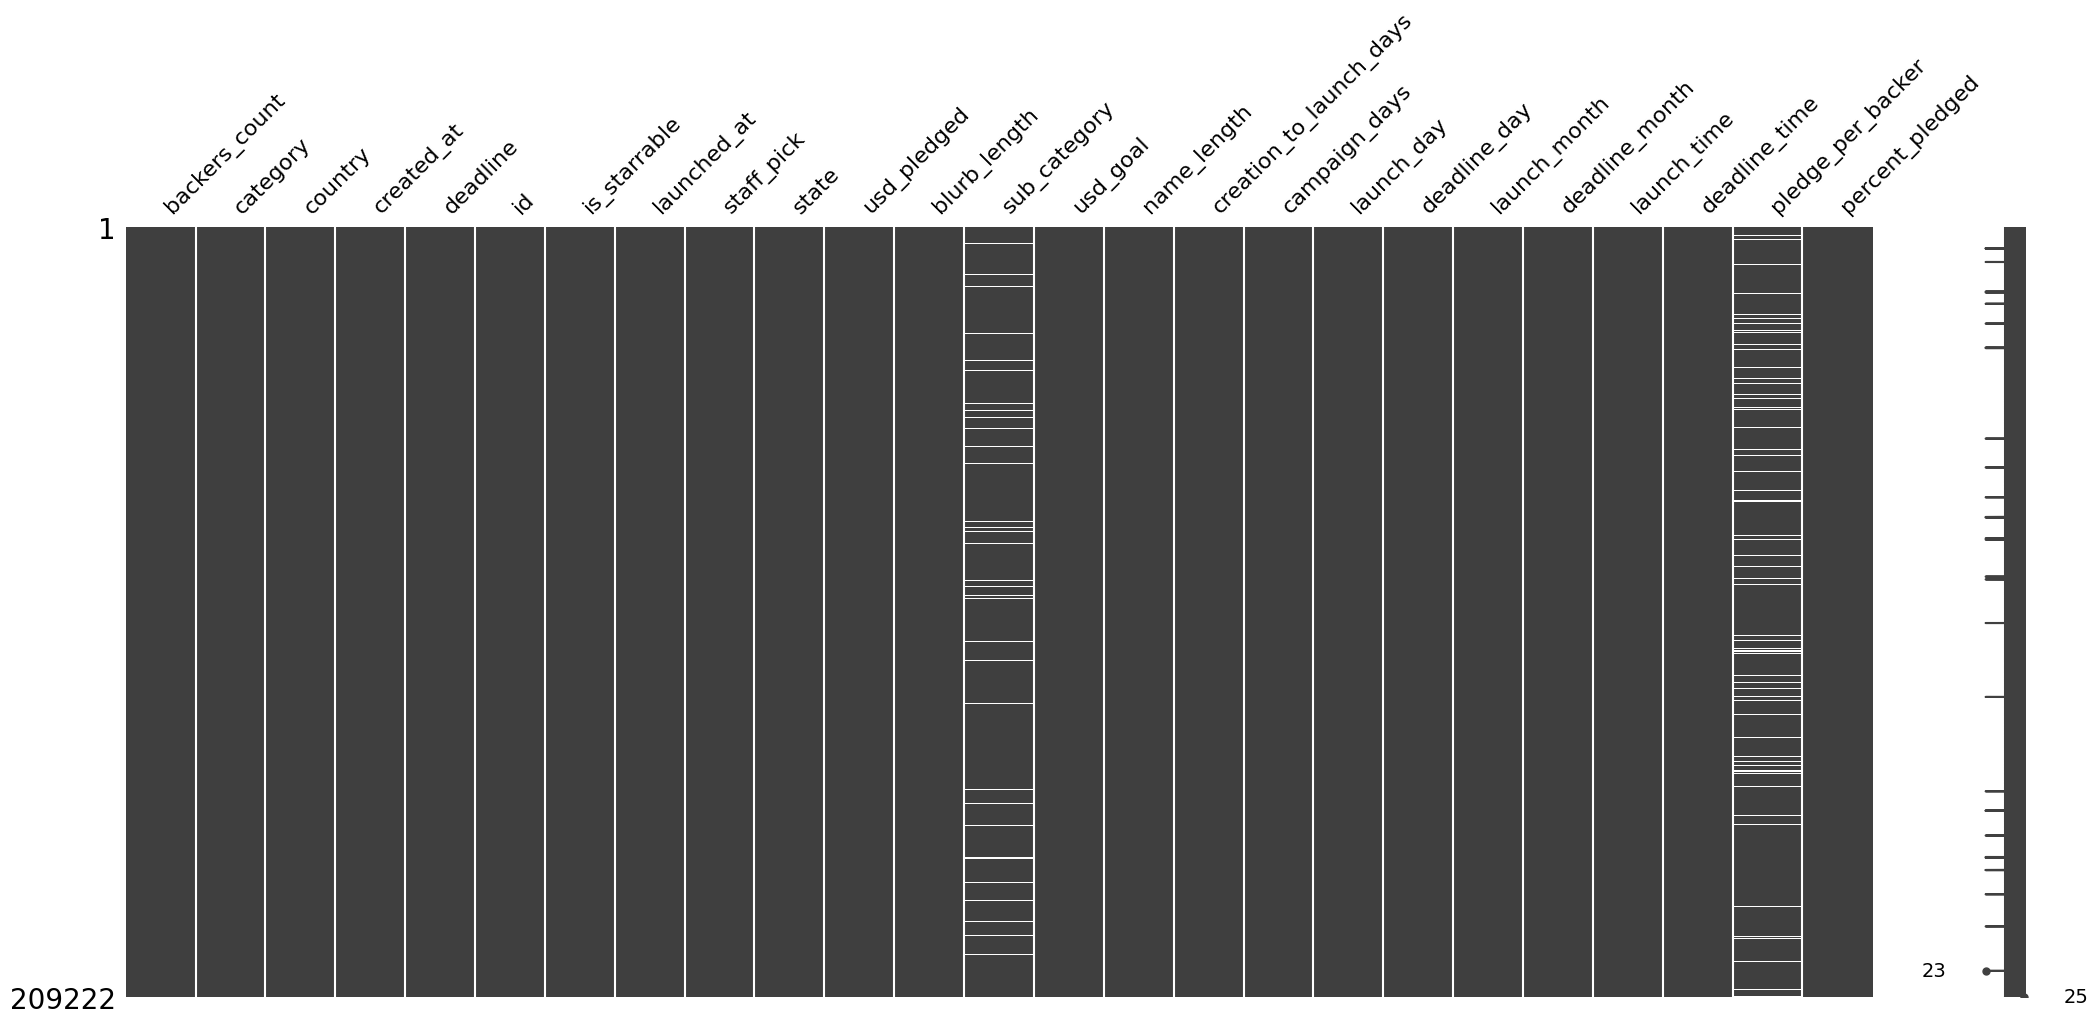

In [49]:
msno.matrix(df)

Blank columns were deleted as below:

In [138]:
#df = df.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1)

In [63]:
# pledge_per_backer missing values
print(df.isna().sum())
print('usd_pledged is 0:',df.usd_pledged[df['usd_pledged']== 0].count())

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   0
sub_category                9041
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
percent_pledged                0
dtype: int64
usd_pledged is 0: 18362


In [80]:
df[df['usd_pledged'] == 0].groupby("state").usd_pledged.count()

state
canceled      3097
failed       15009
live             3
suspended      253
Name: usd_pledged, dtype: int64

In [82]:
# replace missing pledge_per_backer with zeros
df['pledge_per_backer'] = df['pledge_per_backer'].fillna(0)

In [85]:
# did inputting 0 work?
df.pledge_per_backer[df['pledge_per_backer'] == 0].count() 

18362

In [83]:
df.head(2)

,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
0,315,fashion,US,2018-11-06 00:06:45,2019-03-14 06:02:55,2108505034,False,2019-01-23 07:02:55,False,live,28645.0,2,footwear,28000.0,3,17,9,23,14,02,02,07,06,90.94,102.3
1,47,games,US,2017-08-02 16:28:13,2017-09-09 19:00:59,928751314,False,2017-08-10 19:00:59,False,successful,1950.0,22,playing cards,1000.0,4,8,1,10,09,00,00,19,19,41.49,195.0


<AxesSubplot:>

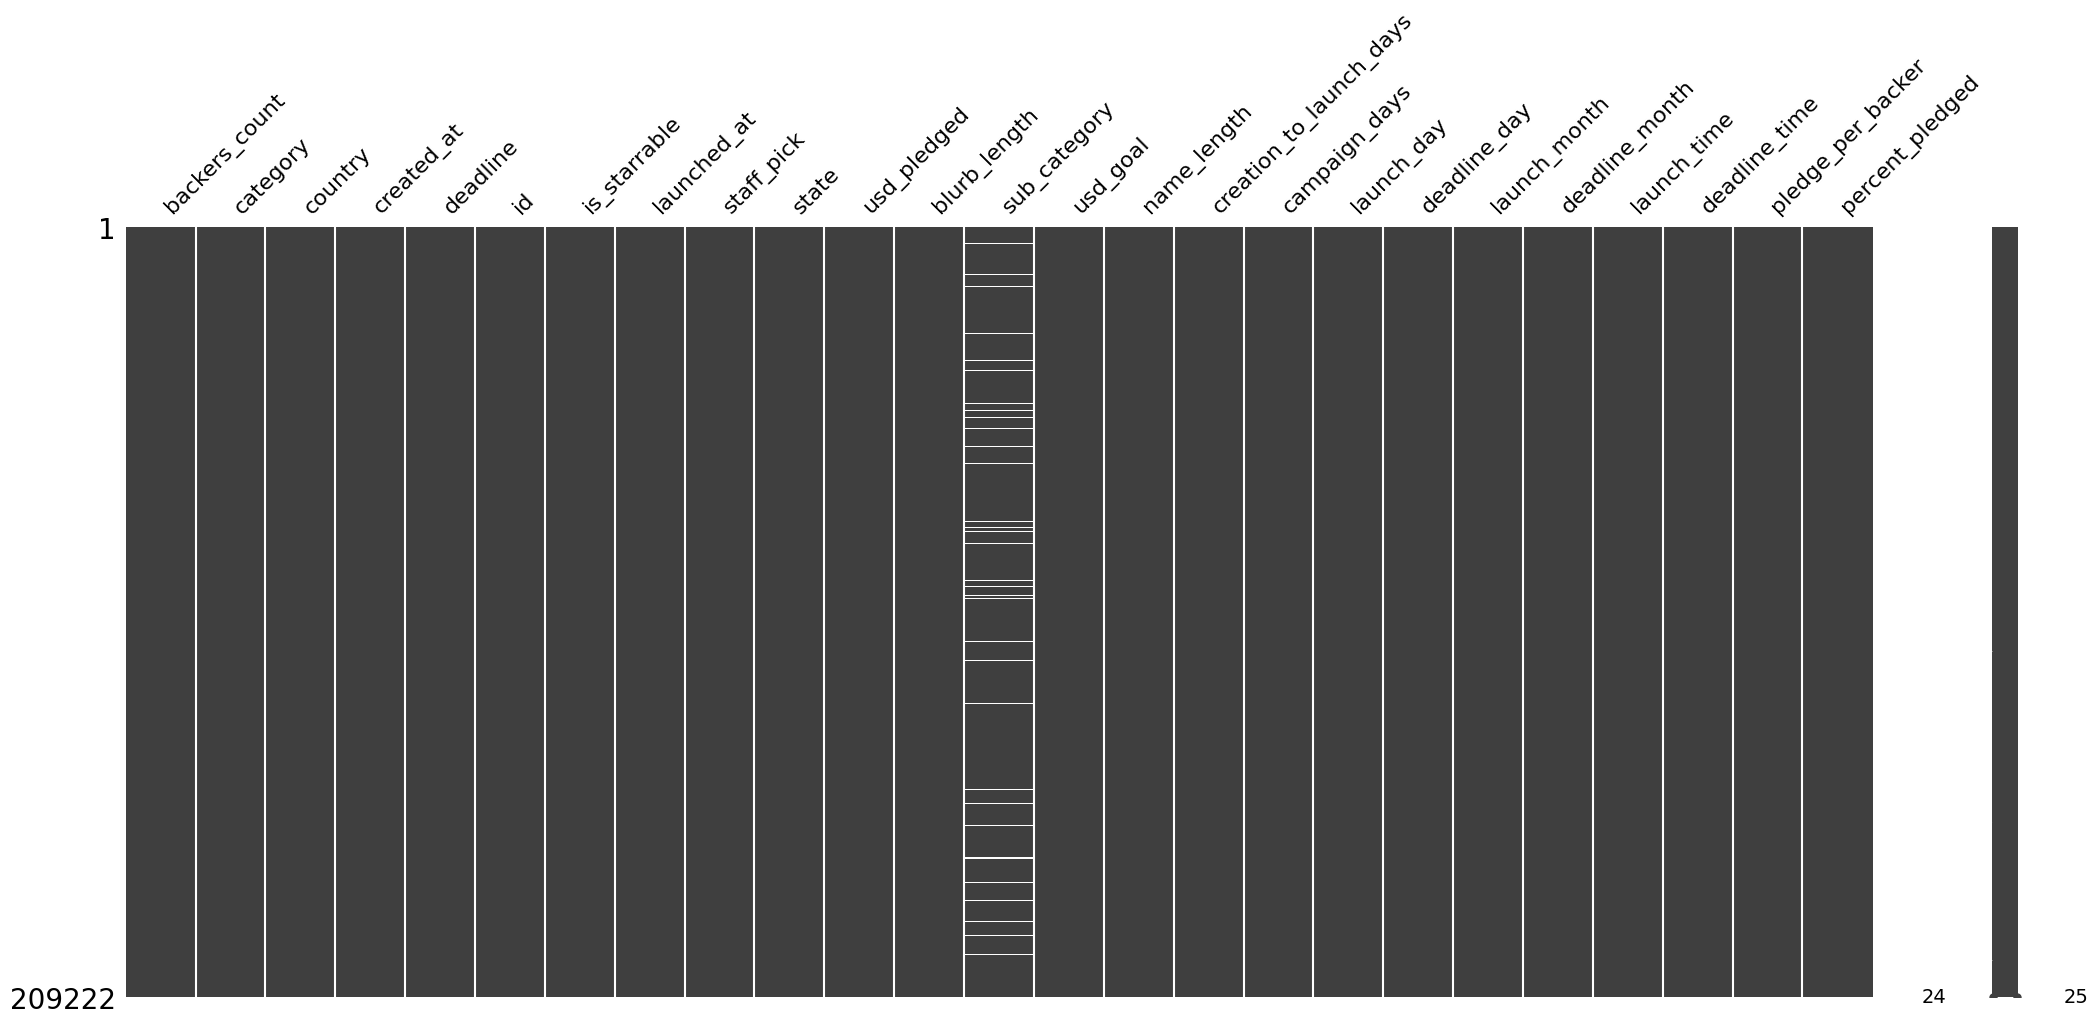

In [86]:
msno.matrix(df)

In [87]:
df.isna().sum()

backers_count                 0
category                      0
country                       0
created_at                    0
deadline                      0
id                            0
is_starrable                  0
launched_at                   0
staff_pick                    0
state                         0
usd_pledged                   0
blurb_length                  0
sub_category               9041
usd_goal                      0
name_length                   0
creation_to_launch_days       0
campaign_days                 0
launch_day                    0
deadline_day                  0
launch_month                  0
deadline_month                0
launch_time                   0
deadline_time                 0
pledge_per_backer             0
percent_pledged               0
dtype: int64

In [88]:
df['sub_category'] = df['sub_category'].fillna('unspecified')
df.isna().sum()

backers_count              0
category                   0
country                    0
created_at                 0
deadline                   0
id                         0
is_starrable               0
launched_at                0
staff_pick                 0
state                      0
usd_pledged                0
blurb_length               0
sub_category               0
usd_goal                   0
name_length                0
creation_to_launch_days    0
campaign_days              0
launch_day                 0
deadline_day               0
launch_month               0
deadline_month             0
launch_time                0
deadline_time              0
pledge_per_backer          0
percent_pledged            0
dtype: int64

**STEP 3** -> The data types were then checked and some inconsistencies were identified to be corrected.

In [89]:
df.dtypes

backers_count                       int64
category                           object
country                            object
created_at                 datetime64[ns]
deadline                   datetime64[ns]
id                                  int64
is_starrable                         bool
launched_at                datetime64[ns]
staff_pick                           bool
state                              object
usd_pledged                       float64
blurb_length                        int64
sub_category                       object
usd_goal                          float64
name_length                         int64
creation_to_launch_days             int64
campaign_days                       int64
launch_day                         object
deadline_day                       object
launch_month                       object
deadline_month                     object
launch_time                        object
deadline_time                      object
pledge_per_backer                 

> Dates were corrected to datetime:

**STEP 4** -> Understanding the dataset:

In [154]:
df['category'].value_counts()

film & video    27678
music           27378
technology      21165
art             20647
publishing      20245
food            16248
games           14035
fashion         12074
design           8889
comics           8805
photography      8119
crafts           7211
theater          6868
journalism       5817
dance            4043
Name: category, dtype: int64

In [156]:
df['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [90]:
df.drop(df[df['state']== 'live'].index, inplace = True)
df.drop(df[df['state']== 'canceled'].index, inplace = True)
df.drop(df[df['state']== 'suspended'].index, inplace = True)

In [91]:
df['state'].value_counts()

successful    117465
failed         75199
Name: state, dtype: int64

**STEP 5** -> Saved new csv file after the dataframe was cleaned and adjusted:

In [160]:
df.to_csv('data/df_cleaned_for_ML.csv',index=False)

### Plotting